In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import codecs
import re

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report

## 資料準備 : 詳細介紹可參考NLP第一階段課程Day20,21

In [2]:
all_data=[]
paths =[r'spam_data/spam', r'spam_data/easy_ham', r'spam_data/hard_ham'] 
for path in paths:
    for fn in glob.glob(path+"/*"):
        if "ham" not in fn:
            is_spam = 1
        else:
            is_spam = 0
        #codecs.open可以避開錯誤，用errors='ignore'
        with codecs.open(fn,encoding='utf-8', errors='ignore') as file:
            for line in file:
                #這個line的開頭為Subject:
                if line.startswith("Subject:"):
                    subject=re.sub(r"^Subject:","",line).strip()
                    all_data.append([subject,is_spam])
all_data = np.array(all_data)
print(len(all_data))

3423


In [3]:
X = all_data[:,0]
Y = all_data[:,1].astype(np.uint8)

In [4]:
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords
import nltk

nltk.download(['omw-1.4','punkt','averaged_perceptron_tagger','wordnet','stopwords'])

# Lemmatize with POS Tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 

## 創建Lemmatizer
lemmatizer = WordNetLemmatizer() 
def get_wordnet_pos(word):
    """將pos_tag結果mapping到lemmatizer中pos的格式"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


def clean_content(X):
    # remove non-alphabet characters
    X_clean = [re.sub('[^a-zA-Z]',' ', x).lower() for x in X]
    # tokenize
    X_word_tokenize = [nltk.word_tokenize(x) for x in X_clean]
    # stopwords_lemmatizer
    X_stopwords_lemmatizer = []
    stop_words = set(stopwords.words('english'))
    for content in X_word_tokenize:
        content_clean = []
        for word in content:
            if word not in stop_words:
                word = lemmatizer.lemmatize(word, get_wordnet_pos(word))
                content_clean.append(word)
        X_stopwords_lemmatizer.append(content_clean)
    
    X_output = [' '.join(x) for x in X_stopwords_lemmatizer]
    
    return X_output

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/xuyouming/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /Users/xuyouming/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/xuyouming/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/xuyouming/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/xuyouming/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
X = clean_content(X)

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
#max_features是要建造幾個column，會按造字出現的頻率高低去篩選，1500並沒有特別含義，大家可以自己嘗試不同數值或不加入限制
cv=CountVectorizer(max_features = 1500)
X=cv.fit_transform(X).toarray()

In [7]:
from sklearn.model_selection import train_test_split
# random_state是為了讓各為學員得到相同的結果，平時可以移除
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [8]:
x_train.shape

(2738, 1500)

In [9]:
np.unique(y_train)

array([0, 1], dtype=uint8)

### 判斷是否有GPU可以使用

In [10]:
device = 'cpu' 

### 模型搭建

In [11]:
class LinearBNAC(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True, dropout=0.3, is_output=False):
        super(LinearBNAC, self).__init__()
        if is_output:
            self.linear = nn.Linear(in_channels, out_channels, bias=bias)
        else:
            self.linear = nn.Sequential(
                nn.Linear(in_channels, out_channels, bias=bias),
                nn.BatchNorm1d(out_channels),
                nn.LeakyReLU(inplace=True),
                nn.Dropout(dropout),
            )
            
    def forward(self, x):
        out=self.linear(x)
        return out

In [12]:
class Model(nn.Module):
    def __init__(self, input_dimention, output_classes=10):
        super(Model, self).__init__()
        self.layer1 = LinearBNAC(input_dimention, 32)
        self.layer2 = LinearBNAC(32, 32)
        self.output = LinearBNAC(32, output_classes, is_output=True)
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.output(x)
        return x  
        

### 建立模型

* to(device) 代表轉成 cpu or gpu 模式 (gpu 模式下稱為 cuda)

In [29]:
model = Model(input_dimention=1500,output_classes=8).to(device=device)

In [30]:
for name,_ in model.named_parameters():
    print(name, _.shape)

layer1.linear.0.weight torch.Size([32, 1500])
layer1.linear.0.bias torch.Size([32])
layer1.linear.1.weight torch.Size([32])
layer1.linear.1.bias torch.Size([32])
layer2.linear.0.weight torch.Size([32, 32])
layer2.linear.0.bias torch.Size([32])
layer2.linear.1.weight torch.Size([32])
layer2.linear.1.bias torch.Size([32])
output.linear.weight torch.Size([8, 32])
output.linear.bias torch.Size([8])


In [31]:
batch_size = 128
input_features = 1500


dummy_input = torch.randn(batch_size, input_features).to(device=device)


In [32]:
output = model(dummy_input)
print(output)

tensor([[-1.8380,  0.4991, -0.7062,  ..., -1.2518, -0.3984, -0.7981],
        [-0.0633,  0.7985,  0.9506,  ..., -0.1482,  0.4594, -0.2216],
        [-0.3538,  0.7533,  0.1743,  ..., -0.3180,  0.0516, -0.7823],
        ...,
        [-0.8664,  1.2919, -0.5765,  ..., -1.7032, -0.2299, -0.8747],
        [-0.4154,  0.7969, -0.5831,  ..., -0.3466,  0.2231,  0.3068],
        [-0.8148,  0.8761, -0.4258,  ..., -0.3974, -0.3977, -0.9221]],
       grad_fn=<AddmmBackward0>)


In [33]:
dummy_input.shape

torch.Size([128, 1500])

In [34]:
output.shape

torch.Size([128, 8])

## Loss

#### classification

In [35]:
from torch.nn import NLLLoss, LogSoftmax, CrossEntropyLoss

In [36]:
## CrossEntropyLoss = LogSoftmax + NLLLoss

* CrossEntropyLoss

In [37]:
criterion = CrossEntropyLoss()

## optimizer

In [38]:
import torch.optim as optim

* params : iterable of parameters
* lr : learning rate
* weight_decay : (L2) Regularization (正則化) 

In [39]:
optimizer = optim.Adam(params=model.parameters(), lr=1e-3)

### 訓練前準備

In [46]:
x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)

y_train_numpy = y_train.clone()
y_test_numpy = y_test.clone()

y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

/var/folders/5x/4wqmzqts3rbfq3bb0z45l_bw0000gn/T/ipykernel_19624/4191977807.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
/var/folders/5x/4wqmzqts3rbfq3bb0z45l_bw0000gn/T/ipykernel_19624/4191977807.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
/var/folders/5x/4wqmzqts3rbfq3bb0z45l_bw0000gn/T/ipykernel_19624/4191977807.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dt

In [62]:
batch_size = 32
epochs = 50
softmax = nn.Softmax(-1)

index = np.array([x for x in range(len(x_train))])

### 訓練

In [63]:
train_loss_ = []
test_loss_ = []
train_accuracy_ = []
test_accuracy_ = []
for epoch in range(epochs):
    
    np.random.shuffle(index)
    x_train = x_train[index]
    y_train = y_train[index]

    loss_keeper = []
    model.train()
    
    for batch in range(len(x_train)//batch_size):
        x = x_train[batch*batch_size : (batch+1)*batch_size,:]
        y = y_train[batch*batch_size : (batch+1)*batch_size]

        # print(x.shape)
        # print(y.shape)

        output = model(x)
        loss_train = criterion(output, y)
        loss_train.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_train = loss_train.detach().cpu().item()
        loss_keeper.append(loss_train)    
    
    model.eval()
    output = model(x_test)
    prediction = softmax(output)
    prediction = torch.argmax(prediction,1).detach().cpu().numpy()
    test_accuracy = metrics.accuracy_score(prediction, y_test_numpy)
    loss_test = criterion(output, y_test)
    loss_test = loss_test.detach().cpu().item()
    train_loss_.append(np.mean(loss_keeper))
    test_loss_.append(loss_test)
    
    if epoch % 2 == 0:
        print('epoch : {}'.format(epoch))
        print('目前 train loss : {:.2f}'.format(np.mean(loss_keeper)))
        print('目前 test loss : {:.2f}'.format(loss_test))
        print('目前 test accuracy : {:.2f}'.format(test_accuracy))


epoch : 0
目前 train loss : 0.05
目前 test loss : 0.27
目前 test accuracy : 0.93
epoch : 2
目前 train loss : 0.04
目前 test loss : 0.27
目前 test accuracy : 0.93
epoch : 4
目前 train loss : 0.05
目前 test loss : 0.28
目前 test accuracy : 0.93
epoch : 6
目前 train loss : 0.05
目前 test loss : 0.28
目前 test accuracy : 0.93
epoch : 8
目前 train loss : 0.05
目前 test loss : 0.30
目前 test accuracy : 0.92
epoch : 10
目前 train loss : 0.04
目前 test loss : 0.28
目前 test accuracy : 0.92
epoch : 12
目前 train loss : 0.04
目前 test loss : 0.31
目前 test accuracy : 0.92
epoch : 14
目前 train loss : 0.05
目前 test loss : 0.28
目前 test accuracy : 0.93
epoch : 16
目前 train loss : 0.04
目前 test loss : 0.29
目前 test accuracy : 0.93
epoch : 18
目前 train loss : 0.04
目前 test loss : 0.30
目前 test accuracy : 0.93
epoch : 20
目前 train loss : 0.04
目前 test loss : 0.30
目前 test accuracy : 0.91
epoch : 22
目前 train loss : 0.04
目前 test loss : 0.28
目前 test accuracy : 0.93
epoch : 24
目前 train loss : 0.04
目前 test loss : 0.28
目前 test accuracy : 0.93
epoch : 26
目前 tra

In [64]:
print(classification_report(prediction, y_test_numpy))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       593
           1       0.71      0.76      0.74        92

    accuracy                           0.93       685
   macro avg       0.84      0.86      0.85       685
weighted avg       0.93      0.93      0.93       685



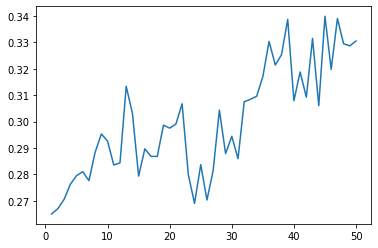

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.arange(1, len(test_loss_)+1), test_loss_)
plt.show()

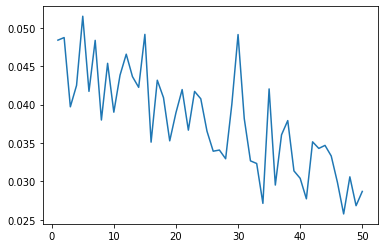

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.arange(1, len(train_loss_)+1), train_loss_)
plt.show()

---

### 儲存跟載入 weight

### 儲存

In [75]:
##假設我們已經訓練好了模型
## 可以存成 .pth or .pt
saving_location = './model_save.pth' # './' 代表目前所屬路徑
torch.save({
    "epoch" : epoch,
    "model_state_dict" : model.state_dict(),
    "loss" : loss_test},
    f=saving_location)

### 載入 

In [76]:
model = Model(input_dimention=1500,output_classes=2).to(device)

##載入
checkpoint = torch.load(saving_location, map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint['model_state_dict'])
print('loading successfully...')
print('\n')

model.eval()

test_content = ['Congratulations! You Get a Free Handheld Organizer!']
test_content = clean_content(test_content)
test_content=cv.transform(test_content).toarray()
test_content = torch.tensor(test_content, dtype=torch.float32).to(device)
output = model(test_content)
prediction = softmax(output)
prediction = torch.argmax(prediction,1).detach().cpu().numpy()[0]

if prediction == 1:
    print('Is spam')
else:
    print('Not spam')

loading successfully...


Is spam
